I am testing using a neural network to recognise patterns in the folded spectra, so that we can revert from a folded spectrum to the original one. Here I test with singles spectra only (i.e. regular Oslo method with Ex tag)

In [14]:
from utilities import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import os

# Simulate spectra. 
Assume max multiplicity 1, and set the pileup probability to 0

In [15]:
# Set some global variables:
N_events = int(1e4)
customLogNorm = LogNorm(vmin=1e0, vmax=N_events)
np.random.seed(124356)

In [16]:
# Import response matrix

fname_resp_mat = 'response_functions/response_matrix-CACTUS-10keV.m'
fname_resp = 'response_functions/resp-CACTUS-10keV.dat'
R_2D, cal_resp, E_resp_array, tmp = read_mama_2D(fname_resp_mat)
# R_2D = div0(R_2D , R_2D.sum(rebin_axis=1))

# Read efficiency and other 1-D response variables:
resp = []
with open(fname_resp) as file:
    # Read line by line as there is crazyness in the file format
    lines = file.readlines()
    for i in range(4,len(lines)):
        try:
            row = np.array(lines[i].split(), dtype="double")
            resp.append(row)
        except:
            break

resp = np.array(resp)
# Name the columns for ease of reading
# FWHM = resp[:,1]
eff = resp[:,2]
# pf = resp[:,3]
# pc = resp[:,4]
# ps = resp[:,5]
# pd = resp[:,6]
# pa = resp[:,7]



Emax = 6000 # keV Crop response matrix (and thus also event generation) to efficiate computation
i_Emax = np.argmin(np.abs(E_resp_array-Emax))
R_2D = R_2D[0:i_Emax,0:i_Emax]
E_resp_array = E_resp_array[0:i_Emax]



# Assumed lower threshold for gammas in response matrix
E_thres = 100 # keV
i_thres = np.argmin(np.abs(E_resp_array - E_thres))
R_2D[:,:i_thres] = 0

for i in range(R_2D.shape[0]):
    norm = R_2D[i,:].sum()
    if(norm>0):
        R_2D[i,:] = R_2D[i,:] / norm #* eff[i]
    else:
        R_2D[i,:] = 0

In [17]:
# === Folding function for a single event ===
def FoldEg(Egs_t, Mf_max, Eg_arr, response, pileup=True, p_pile=0.2):
    """
    This function folds all Egs from a single event.
    """

    
    # print("Folding. True gammas =", Egs_t, flush=True)
    Mt_curr = len(Egs_t[Egs_t>0]) # Number of true gammas

    
    Mf_curr = Mt_curr # Folded multiplicity is the same as true because we do pileup after energy folding

    # Now proceed to fold each gamma with detector response:
    Egs_folded = np.zeros(Mf_curr)
    for i in range(Mf_curr):
        Eg = Egs_t[i]
        index_Eg = np.argmin(np.abs(Eg_arr - Eg))
        if R_2D[index_Eg,:].sum() > 0:
            # choosing rand accounts for the efficiency; As the efficiency read from file currently
            # does not always correspons with the counts in R_2D, see #3, we need two if tests
            rand = np.random.uniform()
            if rand <= eff[index_Eg]:
                # If the gamma is not lost to efficiency, redistribute its energy somewhere in the response:
                Eg_folded = np.random.choice(Eg_arr, p=response[index_Eg,:])
            else: 
                Eg_folded = 0 # Give Energy 0 to events that are not recorded.
        else: 
            Eg_folded = 0 # Give Energy 0 to events that are not recorded (below detector threshold)

        Egs_folded[i] = Eg_folded


    if pileup: # Is pileup desired?
        # For each folded gamma, assign it to pileup with probability p_pile:
        indices_pile = [] # Store indices in Egs_folded
        counter_nopile = 0
        map_to_pileup = {} # Map the indices that are *not* pileup to a new index set so that there are no index holes
                        # For example if Mt = 3 and index 1 is pileup, then map_nopile = {0:0, 2:1}.
                        # Then we decide which of the new indices to add each pileup event to.
        for i_t in range(Mt_curr):
            # Make sure at least one gamma is not assigned to pileup:
            if i_t == Mt_curr-1 and counter_nopile == 0:
                map_to_pileup[i_t] = counter_nopile
                counter_nopile += 1
                break

            # Also make sure no more than 4 gammas remain, by
            # setting pileup probability to 1 if we already have 4 non-piled
            if counter_nopile == 4:
                p_pile = 1

            r_pile = np.random.uniform()
            if r_pile < p_pile:
                # This gamma should be piled.
                indices_pile.append(i_t)
            else:
                # This gamma should not
                map_to_pileup[i_t] = counter_nopile
                counter_nopile += 1

        # Calculate multiplicity of current event after pileup:
        Mf_curr = Mt_curr - len(indices_pile)

        # Decide mapping of pileup gammas:
        for i_t in indices_pile:
            map_to_pileup[i_t] = np.random.randint(0,Mf_curr) if Mf_curr > 0 else 0

        Egs_piled = np.zeros(Mf_curr)
        for i_t in range(Mt_curr):
            Egs_piled[map_to_pileup[i_t]] += Egs_folded[i_t]

    else:
        # Do not include pileup:
        Egs_piled = Egs_folded
        # Mf_curr = Mt_curr

    # print("Piled gammas =", Egs_piled, flush=True)

    return Egs_piled

# Set up event generator and folding functionality

In [18]:
# Set up a function which generates N_events events:
def generate_events(N_events, Mt_max, type="gaussians", args={}):
    events_t = np.zeros((N_events,Mt_max))
    if type == "gaussians":
        Emin = None
        Emax = None
        N_centroids = None
        try:
            Emin = args["Emin"]
        except:        
            Emin = 0
        try:
            Emax = args["Emax"]
        except:
            raise Exception("Argument Emax is required for type gaussians")
        try:
            N_centroids = args["N_centroids"]
        except:
            raise Exception("Argument N_centroids is required for type gaussians")
        
        Eg_gaussian_centroids = np.random.uniform(low=Emin, high=Emax, size=N_centroids)
        for i_ev in range(N_events):
            Mt_curr = np.random.randint(low=1,high=(Mt_max+1))
            Egs_current = np.random.normal(loc=[Eg_gaussian_centroids[np.random.randint(0,N_centroids)] for foo in range(Mt_curr)], scale=0.5*np.sqrt(Eg_gaussian_centroids[0:Mt_curr]), size=Mt_curr)
            events_t[i_ev,0:Mt_curr] = Egs_current 
            #events_t[i_ev,0:Mt_curr] = np.sort(Egs_current)
    elif type == "uniform":
        Emin = None
        Emax = None
        try: 
            Emin = args["Emin"]
        except:
            raise Exception("Argument Emin is required for type uniform")
        try:
            Emax = args["Emax"]
        except:
            raise Exception("Argument Emax is required for type gaussians")
            
        for i_ev in range(N_events):
            Mt_curr = np.random.randint(low=1,high=(Mt_max+1))
            Egs_current = np.random.uniform(low=0, high=Emax, size=Mt_curr)
            events_t[i_ev,0:Mt_curr] = Egs_current
            #events_t[i_ev,0:Mt_curr] = np.sort(Egs_current)
    else:
        raise Exception("Unknown type of spectrum generation")
    
    return events_t





Generate and plot one batch of events:

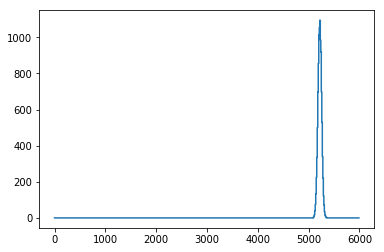

In [19]:
Mt_max = 1 # Max true multiplicity 1
N_centroids = 1 # How many different gaussian centroids to use for the gammas
Emin = 200
Emax = Emax
events_t = generate_events(N_events, Mt_max, type="gaussians", args={"N_centroids":N_centroids,"Emin":Emin,"Emax":Emax})

# == Sort and plot true events ==
E_t_array = E_resp_array
N_Eg = len(E_t_array)
counts_true = np.zeros((N_Eg))

# Sort data:
for i_ev in range(N_events):
    counts_true[np.argmin(np.abs(E_t_array-events_t[i_ev,0]))] += 1

# Plot by Eg axes
plt.step(E_t_array, counts_true)
plt.show()

Set up folding function for N_events events

In [20]:
def fold_events(events_t, pileup=False, p_pile=0, Mf_max=1):
    # Simulate folding
    events_f = np.zeros((N_events, Mf_max))
    for i_ev in range(events_t.shape[0]):
        Egs_folded = FoldEg(events_t[i_ev,:], Mf_max=Mf_max, Eg_arr=E_resp_array, response=R_2D, pileup=pileup, p_pile=p_pile)
        #events_f[i_ev,0:len(Egs_folded)] = Egs_folded
        events_f[i_ev,0:len(Egs_folded)] = np.sort(Egs_folded)
    return events_f


Run it on one batch

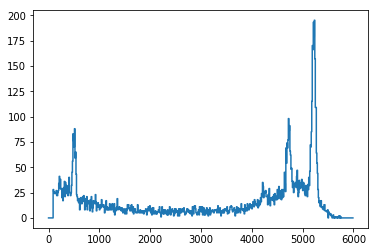

In [21]:

pileup = False
p_pile = 0
Mf_max = 1
events_f = fold_events(events_t, pileup=pileup, p_pile=p_pile, Mf_max=Mf_max)

# Sort and plot folded events 
E_f_array = E_resp_array
N_Eg = len(E_f_array)
counts_folded = np.zeros((N_Eg))

# Sort data:
for i_ev in range(N_events):
    counts_folded[np.argmin(np.abs(E_f_array-events_f[i_ev,0]))] += 1
    
# Remove counts in channel zero, in this 1D way of thinking they would be below threshold (no coincidences and pileup correction)
counts_folded[0] = 0

# Plot by Eg axes
plt.step(E_t_array, counts_folded)
plt.show()

# It works, now generate an ensemble of spectra

In [23]:
# Generate true events:
N_ensemble = 200 # How many ensemble members?
N_events = int(1e4) # Events per ensemble
Mt_max = 1 # Max true multiplicity 2
purge_files = False # Regenerate simulations, or load from file if possible?

# Set calibration to use, should not be too large because of neural network
a0, a1 = 0, 20 # keV
N_nn = int(Emax/a1 - a0)
E_nn_array = np.linspace(a0, a0+(N_nn-1)*a1, N_nn)

N_centroids = 1 # How many different gaussian centroids to use for the gammas

fname_ensemble_counts_true = "1D-ensemble_counts_true-"+str(N_ensemble)+"_members-"+str(N_centroids)+"_gaussian_centroids.npy"
if os.path.exists(fname_ensemble_counts_true) and not purge_files:
    ensemble_counts_true = np.load(fname_ensemble_counts_true)
    ensemble_counts_true = ensemble_counts_true.reshape((N_ensemble, N_nn))
else:

    memory_requirement = N_ensemble*N_events*Mt_max*8 / (1024)**2 # MB
    print("memory required to store event lists: {:.2f} MB".format(memory_requirement), flush=True)

    ensemble_list_true = []
    for i_ens in range(N_ensemble):
        if i_ens % 10 == 0:
            print("Ensemble member", i_ens, flush=True)
        events_t = generate_events(N_events, Mt_max, type="gaussians", args={"N_centroids":N_centroids,"Emin":Emin,"Emax":Emax})
        ensemble_list_true.append(events_t)

    
    
    
    # Sort each ensemble member:
    E_t_array = E_resp_array
    N_Eg = len(E_t_array)

    # Sort data:
    #counts_true = np.zeros((N_nn, N_nn))
    ensemble_counts_true = np.zeros((N_ensemble, N_nn))
    print("Sorting data", flush=True)
    for i_ens in range(N_ensemble):
        events_t = ensemble_list_true[i_ens]
        for i_ev in range(N_events):
            ensemble_counts_true[i_ens, np.argmin(np.abs(E_nn_array-events_t[i_ev,0]))] += 1

    np.save(fname_ensemble_counts_true, ensemble_counts_true)

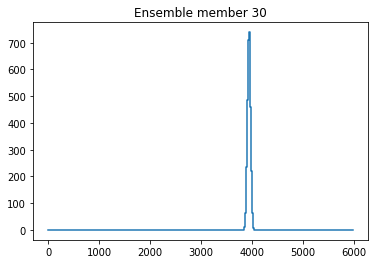

In [24]:
# Plot by Eg axes
index = np.random.randint(0,N_ensemble-1)
plt.step(E_nn_array, ensemble_counts_true[index,:])
plt.title("Ensemble member "+str(index))
plt.show()


In [26]:
# Simulate folding for each member:
Mf_max = 1

fname_ensemble_counts_folded = "1D-ensemble_counts_folded-"+str(N_ensemble)+"_members-"+str(N_centroids)+"_gaussian_centroids.npy"
if os.path.exists(fname_ensemble_counts_folded) and not purge_files:
    ensemble_counts_folded = np.load(fname_ensemble_counts_folded)
    ensemble_counts_folded = ensemble_counts_folded.reshape((N_ensemble, N_nn))
else:
    ensemble_list_folded = []
    for i_ens in range(N_ensemble):
        if i_ens % 10 == 0:
            print("Ensemble member {:d}".format(i_ens), flush=True)
        events_t = ensemble_list_true[i_ens]
        events_f = fold_events(events_t, Mf_max=Mf_max)
        ensemble_list_folded.append(events_f)
    
    
    
    # Sort all ensemble members and plot same random member as above:
    ensemble_counts_folded = np.zeros((N_ensemble, N_nn))

    # Sort data:
    events_f = ensemble_list_folded[index]
    for i_ens in range(N_ensemble):
        events_f = ensemble_list_folded[i_ens]
        for i_ev in range(N_events):
            ensemble_counts_folded[i_ens, np.argmin(np.abs(E_nn_array-events_f[i_ev,0]))] += 1
        # Remove counts in channel 0 for this 1D example where we have no pileup correction -- these events are then simply below threshold
        ensemble_counts_folded[i_ens, 0] = 0
            
    # Plot by Eg axes
    plt.step(E_nn_array, ensemble_counts_folded[index,:])
    plt.title("Ensemble member "+str(index))
    plt.show()

    np.save(fname_ensemble_counts_folded, ensemble_counts_folded)

# Set up the neural network

I adapt something from the TensorFlow tutorial, https://www.tensorflow.org/tutorials/keras/basic_regression

First, normalize each spectrum in the ensemble to unity:

ensemble_counts_folded.sum(axis=1) =
[3000. 3000. 3000. 2922. 3000. 3000. 3000. 3000. 2948. 3000. 3000. 3000.
 2981. 3000. 3000. 3000. 3000. 3000. 3000. 2904. 2745. 3000. 3000. 3000.
 2513. 3000. 2862. 3000. 3000. 2570. 3000. 3000. 3000. 2889. 3000. 3000.
 3000. 2903. 3000. 3000. 3000. 3000. 3000. 2886. 3000. 2711. 3000. 2991.
 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000.
 3000. 3000. 3000. 3000. 2998. 3000. 3000. 3000. 3000. 3000. 3000. 2381.
 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 2697. 3000.
 3000. 3000. 2999. 2954. 3000. 3000. 3000. 3000. 2965. 3000. 2916. 2318.
 3000. 3000. 3000. 2747. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000.
 3000. 3000. 3000. 3000. 3000. 2692. 2939. 3000. 3000. 3000. 2699. 3000.
 2415. 2747. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 2653. 3000. 3000.
 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000.
 3000. 2388. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000. 3000.
 3000. 2574. 3

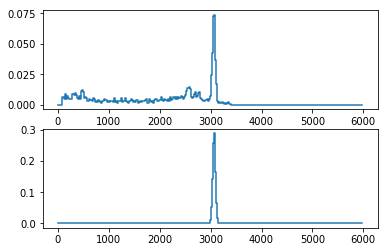

In [27]:
print("ensemble_counts_folded.sum(axis=1) =")
print(ensemble_counts_folded.sum(axis=1))

train_in = ensemble_counts_folded / ensemble_counts_folded.sum(axis=1).reshape((ensemble_counts_folded.shape[0],1))
print("train_in.shape =", train_in.shape)
train_out = ensemble_counts_true / ensemble_counts_true.sum(axis=1).reshape((ensemble_counts_folded.shape[0],1))
print("train_out.shape =", train_out.shape)
f, (ax1, ax2) = plt.subplots(2,1)
index=36
ax1.step(E_nn_array, train_in[index,:])
ax2.step(E_nn_array, train_out[index,:])
plt.show()

Then set up the TensorFlow model using Keras, with a couple of dense hidden layers:

In [29]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(4*N_nn, activation=tf.nn.relu,
                       input_shape=(N_nn,)),
    keras.layers.Dense(4*N_nn, activation=tf.nn.relu),
    keras.layers.Dense(N_nn)
  ])

optimizer = tf.train.RMSPropOptimizer(0.001)
#optimizer = tf.train.RMSPropOptimizer(0.01) # Does not work as well

model.compile(loss='mean_squared_error',
            optimizer=optimizer,
            metrics=['mae'])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

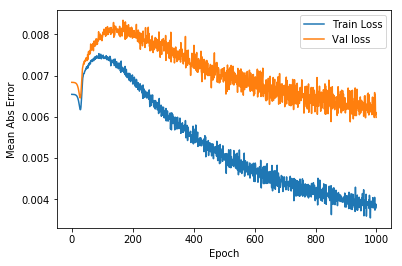

In [30]:
# Train network
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')
EPOCHS = 500
history = model.fit(train_in, train_out, epochs=EPOCHS,
                    validation_split=0.2, verbose=0,
                    callbacks=[PrintDot()])


# Plot training and validation loss as function of epochs:
import matplotlib.pyplot as plt
def plot_history(history):
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(history.epoch, np.array(history.history['mean_absolute_error']),
           label='Train Loss')
  plt.plot(history.epoch, np.array(history.history['val_mean_absolute_error']),
           label = 'Val loss')
  plt.legend()
  #plt.ylim([0, 5])

plot_history(history)

In [31]:
# Generate and check against new test data:
Mt_max = 1 # Max true multiplicity 1
# Simulate pileup
pileup = False
p_pile = 0
Mf_max = 1


np.random.seed(1245)
N_test = 4
# Can try a more complicated spectrum for the test, to see what happens, by setting N_centroids > 1:
N_centroids = 1


fname_ensemble_test_counts_true = "1D-ensemble_test_counts_true-"+str(N_test)+"_members-"+str(N_centroids)+"_gaussian_centroids.npy"
fname_ensemble_test_counts_folded = "1D-ensemble_test_counts_folded-"+str(N_test)+"_members-"+str(N_centroids)+"_gaussian_centroids.npy"
if os.path.exists(fname_ensemble_test_counts_true) and os.path.exists(fname_ensemble_test_counts_folded) and not purge_files:
    ensemble_test_counts_true = np.load(fname_ensemble_test_counts_true)
    ensemble_test_counts_true = ensemble_test_counts_true.reshape((N_test, N_nn))
    ensemble_test_counts_folded = np.load(fname_ensemble_test_counts_folded)
    ensemble_test_counts_folded = ensemble_test_counts_folded.reshape((N_test, N_nn))
else:
    ensemble_test_counts_true = np.zeros((N_test, N_nn))
    ensemble_test_counts_folded = np.zeros((N_test, N_nn))
    for i_test in range(N_test):
        events_t = generate_events(N_events, Mt_max, type="gaussians", args={"N_centroids":N_centroids,"Emin":Emin,"Emax":Emax})
        events_f = fold_events(events_t, pileup=pileup, p_pile=p_pile, Mf_max=Mf_max)
    
        # Sort
        for i_ev in range(N_events):
            ensemble_test_counts_true[i_test, np.argmin(np.abs(E_nn_array-events_t[i_ev,0]))] += 1
            ensemble_test_counts_folded[i_test, np.argmin(np.abs(E_nn_array-events_f[i_ev,0]))] += 1
            
            
            
    np.save(fname_ensemble_test_counts_true, ensemble_test_counts_true)
    np.save(fname_ensemble_test_counts_folded, ensemble_test_counts_folded)
            
            
ensemble_test_counts_true /= ensemble_test_counts_true.sum(axis=1).reshape((ensemble_test_counts_true.shape[0],1))
ensemble_test_counts_folded /= ensemble_test_counts_folded.sum(axis=1).reshape((ensemble_test_counts_folded.shape[0],1))

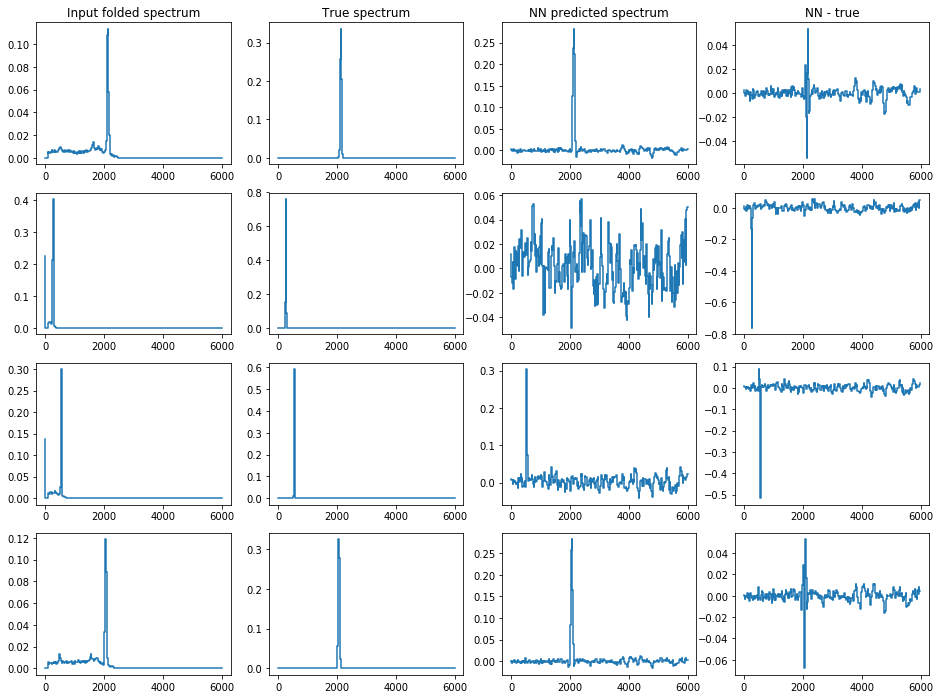

In [33]:
# Plot true and predicted for each member of test ensemble:
f, axs = plt.subplots(N_test,4)

ensemble_test_counts_predicted = model.predict(ensemble_test_counts_folded)
#ensemble_test_counts_predicted = ensemble_test_counts_predicted.reshape((N_test, N_nn))

for i_test in range(N_test):
    axs[i_test,0].step(E_nn_array, ensemble_test_counts_folded[i_test,:])
    axs[i_test,1].step(E_nn_array, ensemble_test_counts_true[i_test,:])
    axs[i_test,2].step(E_nn_array, ensemble_test_counts_predicted[i_test,:])
    axs[i_test,3].step(E_nn_array, ensemble_test_counts_predicted[i_test,:]-ensemble_test_counts_true[i_test,:])

    
    
axs[0,0].set_title("Input folded spectrum")
axs[0,1].set_title("True spectrum")
axs[0,2].set_title("NN predicted spectrum")
axs[0,3].set_title("NN - true")
   
f.set_size_inches(16,3*N_test)